# Generating FBM Samples wrt Time, using FBM library

* We can observe that increasing hurst parameter, we get smoother relaisations of motion.

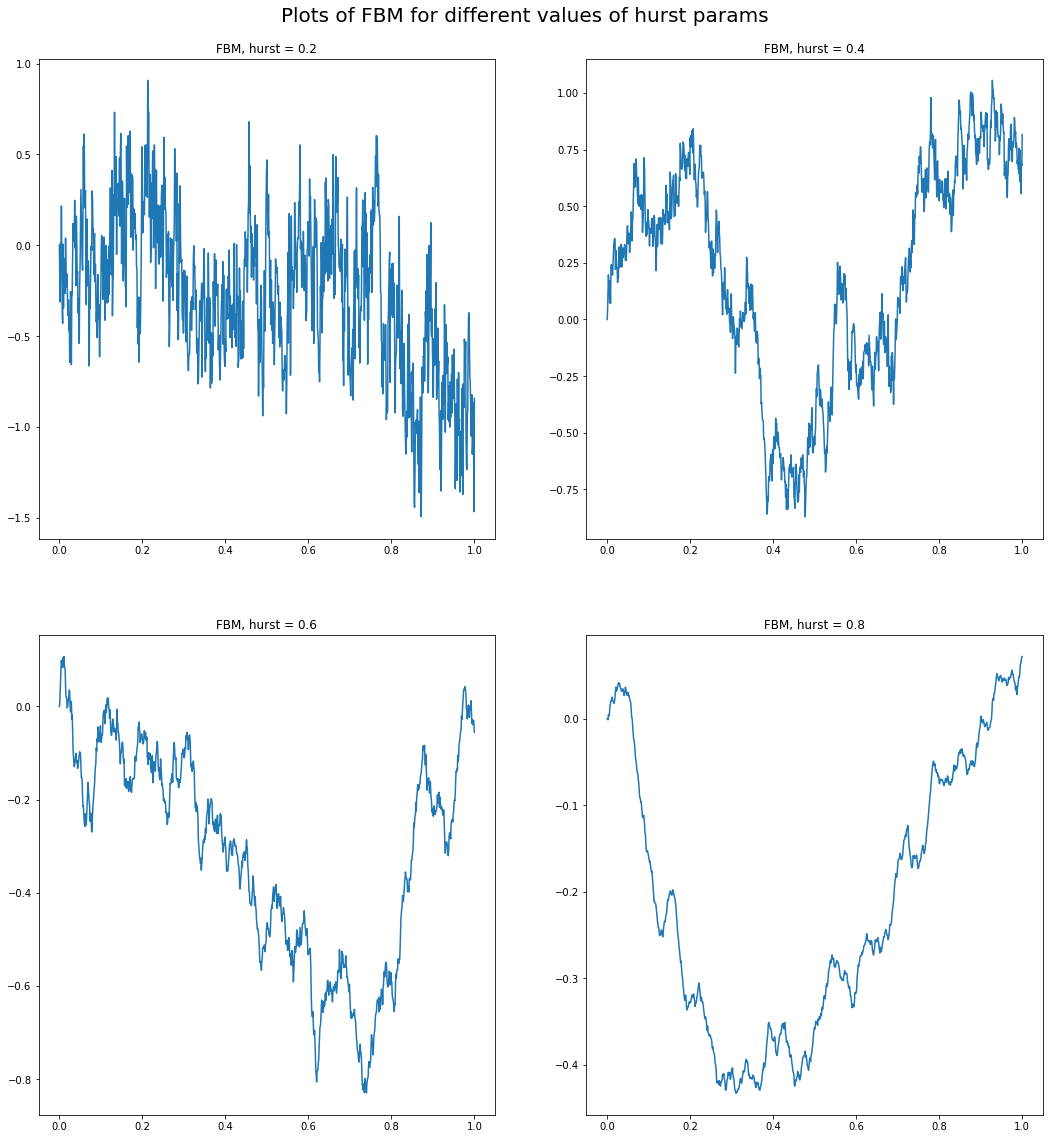

In [2]:
%matplotlib inline

from fbm import FBM
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, ifft, fftfreq

def plt_fbm(h_param,num_samp,subplot_index=111):
    f = FBM(n=num_samp, hurst=h_param, length=1, method='cholesky')
    # Generate a fBm realization
    fbm_sample = f.fbm()

    # Get the times associated with the fBm
    t_values = f.times()
    
    ax= fig.add_subplot(subplot_index)
    ax.set_title("FBM, hurst = "+str(h_param))
    ax.plot(t_values,fbm_sample)
    #print(t_values)
    return fbm_sample

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
fig.tight_layout()
fig.subplots_adjust(top=0.94)
fbm_samps=[]
plt.suptitle("Plots of FBM for different values of hurst params",fontsize=20)
num_pts=1000
t_samp=np.linspace(0,1,num_pts+1)
fbm_samps.append(plt_fbm(0.2,num_pts,221))
fbm_samps.append(plt_fbm(0.4,num_pts,222))
fbm_samps.append(plt_fbm(0.6,num_pts,223))
fbm_samps.append(plt_fbm(0.8,num_pts,224))
plt.show()

# Plotting the FFT of FBM motion as well

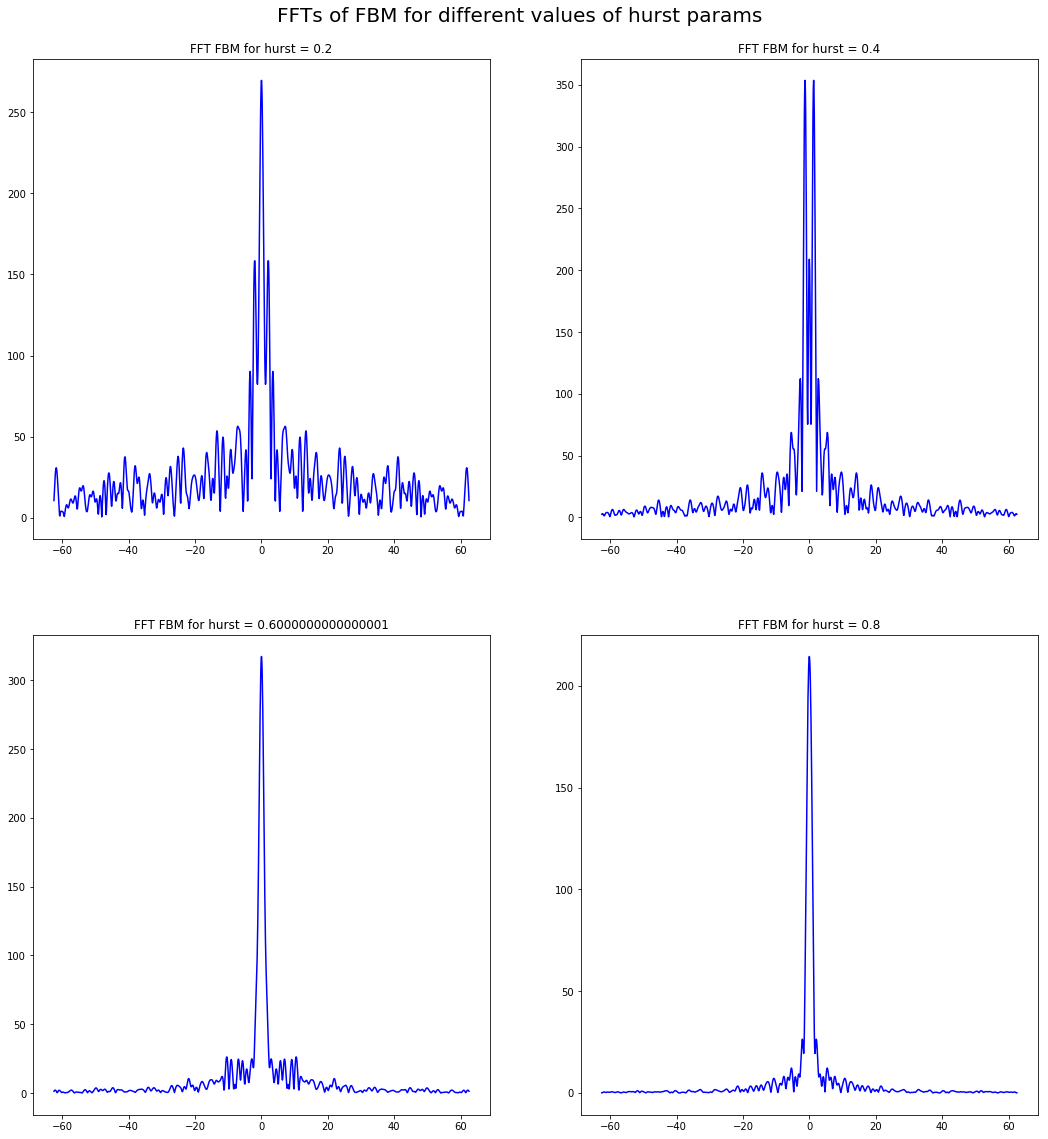

In [3]:
def plot_fft(fbm_vals,hurst,subplot_index=111):
    samp_freq=1000
    NFFT=10*t_samp.shape[0]
    zp_arr=np.append(np.array(fbm_vals),np.zeros(NFFT-len(fbm_vals)))
    fbm_freq=np.fft.fftshift(fft(zp_arr,NFFT))
    disc_w=np.linspace(-samp_freq/16,samp_freq/16,NFFT//8)
    ax= fig.add_subplot(subplot_index)
    ax.set_title("FFT FBM for hurst = "+str(hurst))
    ax.plot(disc_w,abs(fbm_freq[NFFT//2-NFFT//16:NFFT//2+NFFT//16+1]),'b')
    return fbm_freq[0:NFFT//2]

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.suptitle("FFTs of FBM for different values of hurst params",fontsize=20)
subplot_list=[221,222,223,224]
freq_fbm_samps=[]
for i in range(len(fbm_samps)): 
    freq_fbm_samps.append(plot_fft(fbm_samps[i],0.2*(i+1),subplot_list[i]))
plt.show()


# PCA spectrum of single FBM signals


0.597413789025


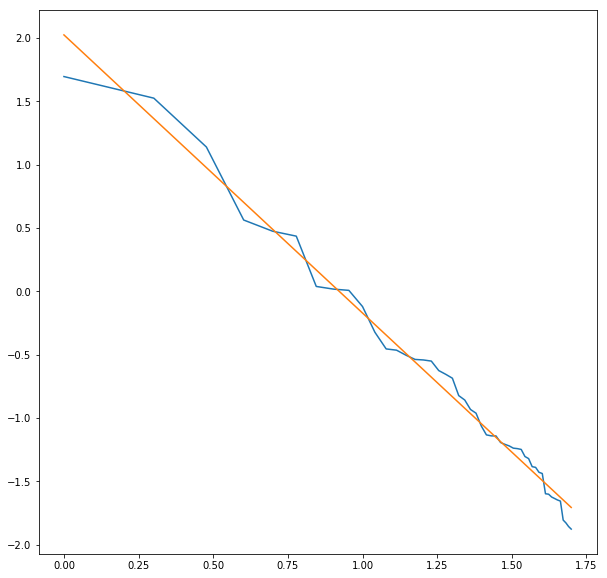

In [64]:
from scipy.ndimage.interpolation import shift
from scipy.linalg import toeplitz,inv,svd
from scipy.optimize import curve_fit

def Lf(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

M=50
H=0.6
f = FBM(n=M, hurst=H, length=0.5, method='daviesharte')
# Generate a fBm realization
fbm_sample = f.fbm()
# Get the times associated with the fBm
t_values = f.times()
#print(t_values)
# plt.plot(t_values,fbm_sample)
# plt.show()

R=np.zeros(M+1) #Autocorrelation: r[0] to r[p-1]

for k in range(M+1):
    fbm_shift=shift(fbm_sample, k, cval=0)
    R[k]=np.sum(fbm_sample*np.conjugate(fbm_shift))

AutoCorr_mat=toeplitz(R[0:M],R[0:M])

num_sim=50
for i in range(num_sim):
    M=50
    H=0.6
    f1 = FBM(n=M, hurst=H, length=0.5, method='daviesharte')
    # Generate a fBm realization
    if(i==0):
        avg_sample=f1.fgn()
    else:
        avg_sample += f1.fgn()

#mean_vec=[t_values[i]**(2*H) for i in range(0,M)]
mean_vec=avg_sample/num_sim
AutoCov_mat=AutoCorr_mat-np.outer(mean_vec,mean_vec)

U,S,V=svd(AutoCov_mat)
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(np.log10(np.arange(M)+1),np.log10(S))

expected_slope=-(2*H+1)
A,B = curve_fit(Lf,np.log10(np.arange(M)+1),np.log10(S))[0] # your data x, y to fit
print(-(A+1)/2)
plt.plot([0,np.log10(M)],[B,A*np.log10(M)+B])
plt.show()

#print(S)
